<a href="https://colab.research.google.com/github/adampotton/Cognitive_AI_CW/blob/main/Q2A_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .

In [3]:
import neurogym as ngym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import time

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


### Define a simple LSTM model

In [4]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_lstm_layers = 2):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_lstm_layers) # n LSTM layers
        self.fc = nn.Linear(hidden_size, output_size) # Fully connected layer

    def forward(self, x):
        lstm_output, _ = self.lstm(x)
        out = self.fc(lstm_output)
        return out, lstm_output

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Creating dataset and adjusting parameters

In [70]:
config = {
    'dt': 200, # Timestep parameter
    'hidden_size': 32, # Hidden size for your LSTM
    'batch_size': 32, # Batch size for training
    'seq_len': 50, # Sequence length for input data
    'envid': 'ReadySetGo-v0', # Task name
    'gain': 2, # Custom gain
    'prod_margin': 10, # Custom production margin
}

env_kwargs = {
    'dt': config['dt'], # Assing timestep parameter
    'gain': config['gain'],  # Controls the measure that the agent has to produce
    'prod_margin': config['prod_margin'], # Controls the interval around the ground truth production time within which the agent receives proportional reward
}
config['env_kwargs'] = env_kwargs

dataset = ngym.Dataset(config['envid'], env_kwargs=config['env_kwargs'], batch_size=config['batch_size'], seq_len=config['seq_len']) # Generate dataset
env = dataset.env

inputs, target = dataset() # Assing inputs and targets
inputs = torch.from_numpy(inputs).type(torch.float)

input_size = env.observation_space.shape[0] # Find dimensions for data
output_size = env.action_space.n

print('Input has shape (SeqLen, Batch, Dim) =', inputs.shape)
print('Target has shape (SeqLen, Batch) =', target.shape)

Input has shape (SeqLen, Batch, Dim) = torch.Size([50, 32, 3])
Target has shape (SeqLen, Batch) = (50, 32)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


### Training the model

In [73]:
iter_steps = 3000 # Training loops
report_freq = 50 # How often a report on is returned

net = LSTMNet(input_size, config['hidden_size'], output_size, num_lstm_layers = 2) # Create an instance of the LSTM

def train_model(net, dataset, iter_steps, report_freq):

    optimizer = optim.Adam(net.parameters(), lr=0.0003) # Adam optimiser
    criterion = nn.CrossEntropyLoss() # Loss funciton

    running_loss = 0
    running_acc = 0
    losses = []
    accuracies = []
    start_time = time.time() # Start training timer

    for i in range(iter_steps):  # Loop over training batches
        inputs, labels = dataset()  # Generate a set of data
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        optimizer.zero_grad()  # Reset gradients
        output, _ = net(inputs)
        output = output.view(-1, output_size)
        loss = criterion(output, labels)  # Calculate loss
        loss.backward()
        optimizer.step()  # Update weights

        batch_acc = (torch.argmax(output, dim=1) == labels).sum().item() / labels.shape[0]  # Current batch accuracy
        losses.append(loss.item())
        accuracies.append(batch_acc)

        if i % report_freq == report_freq - 1:
            running_loss = sum(losses[-report_freq:]) / report_freq
            running_acc = sum(accuracies[-report_freq:]) / report_freq
            print('Step {}, Loss {:0.4f}, Accuracy {:0.4f}, Time {:0.1f}s'.format(
                i + 1, running_loss, running_acc, time.time() - start_time))
            running_loss = 0 # Reset metrics for next report
            running_acc = 0
    return net, losses, accuracies

net, losses, accuracies = train_model(net, dataset, iter_steps, report_freq) # Call the training function

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Step 50, Loss 0.7179, Accuracy 0.3364, Time 0.9s
Step 100, Loss 0.3746, Accuracy 0.9537, Time 1.6s
Step 150, Loss 0.1928, Accuracy 0.9621, Time 2.4s
Step 200, Loss 0.1875, Accuracy 0.9624, Time 3.5s
Step 250, Loss 0.1832, Accuracy 0.9623, Time 4.7s
Step 300, Loss 0.1807, Accuracy 0.9623, Time 5.8s
Step 350, Loss 0.1776, Accuracy 0.9620, Time 6.6s
Step 400, Loss 0.1694, Accuracy 0.9622, Time 7.4s
Step 450, Loss 0.1579, Accuracy 0.9622, Time 8.2s
Step 500, Loss 0.1461, Accuracy 0.9622, Time 9.0s
Step 550, Loss 0.1374, Accuracy 0.9624, Time 9.7s
Step 600, Loss 0.1292, Accuracy 0.9622, Time 10.5s
Step 650, Loss 0.1192, Accuracy 0.9621, Time 11.4s
Step 700, Loss 0.1103, Accuracy 0.9623, Time 12.2s
Step 750, Loss 0.1027, Accuracy 0.9625, Time 12.9s
Step 800, Loss 0.0918, Accuracy 0.9649, Time 13.8s
Step 850, Loss 0.0817, Accuracy 0.9859, Time 14.5s
Step 900, Loss 0.0730, Accuracy 0.9899, Time 15.3s
Step 950, Loss 0.0644, Accuracy 0.9904, Time 16.4s
Step 1000, Loss 0.0624, Accuracy 0.9897, Ti

### Plot loss and accuracy over iterations

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


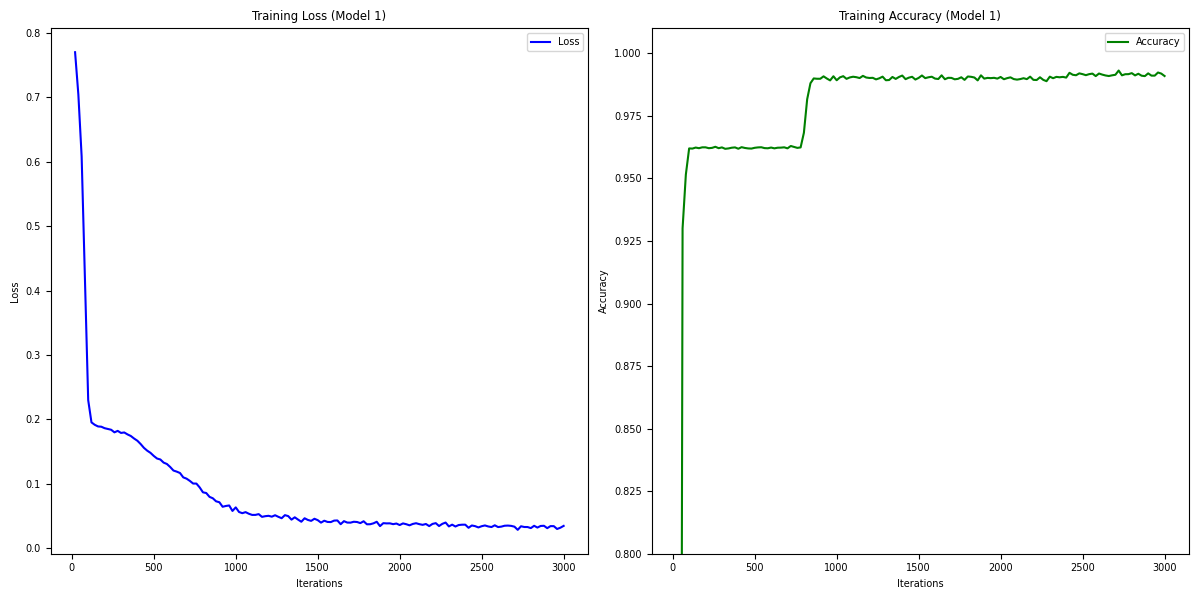

In [77]:
avg_losses = []
avg_accuracies = []
report_freq = 20
for i in range(report_freq - 1, len(losses), report_freq):
    avg_losses.append(sum(losses[i-report_freq+1:i+1]) / report_freq)
    avg_accuracies.append(sum(accuracies[i-report_freq+1:i+1]) / report_freq)

iterations = range(report_freq, len(losses) + 1, report_freq)

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

# Plot Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(iterations, avg_losses, label='Loss', color='blue')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss (Model 1)')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(iterations, avg_accuracies, label='Accuracy', color='green')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.01)
plt.title('Training Accuracy (Model 1)')
plt.legend()

plt.tight_layout()
plt.show()

In [79]:
env = dataset.env # Reset environment
env.reset(no_step=True)

perf = 0 # Initialize loggin vars
activity_dict = {}
trial_infos = {}

num_trial = 2000
for i in range(num_trial):

    trial_info = env.new_trial() # New trial
    ob, gt = env.ob, env.gt # Observation and groud-truth of this trial
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)

    action_pred, rnn_activity = net(inputs) # Run network for one trial

    action_pred = action_pred.detach().numpy()[:, 0, :] # Compute performance
    choice = np.argmax(action_pred[-1, :]) # Final choice at final time step
    correct = choice == gt[-1]

    rnn_activity = rnn_activity[:, 0, :].detach().numpy() # Record activity
    activity_dict[i] = rnn_activity
    trial_infos[i] = trial_info  # Record trial infos
    trial_infos[i].update({'correct': correct})

for i in range(20):
    print('Trial ', i, trial_infos[i])

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Trial  0 {'measure': 1200.0, 'gain': 2, 'production': 2400.0, 'correct': True}
Trial  1 {'measure': 1200.0, 'gain': 2, 'production': 2400.0, 'correct': True}
Trial  2 {'measure': 1000.0, 'gain': 2, 'production': 2000.0, 'correct': True}
Trial  3 {'measure': 1000.0, 'gain': 2, 'production': 2000.0, 'correct': True}
Trial  4 {'measure': 1000.0, 'gain': 2, 'production': 2000.0, 'correct': True}
Trial  5 {'measure': 1000.0, 'gain': 2, 'production': 2000.0, 'correct': True}
Trial  6 {'measure': 1200.0, 'gain': 2, 'production': 2400.0, 'correct': True}
Trial  7 {'measure': 1000.0, 'gain': 2, 'production': 2000.0, 'correct': True}
Trial  8 {'measure': 1200.0, 'gain': 2, 'production': 2400.0, 'correct': True}
Trial  9 {'measure': 800.0, 'gain': 2, 'production': 1600.0, 'correct': True}
Trial  10 {'measure': 1000.0, 'gain': 2, 'production': 2000.0, 'correct': True}
Trial  11 {'measure': 800.0, 'gain': 2, 'production': 1600.0, 'correct': True}
Trial  12 {'measure': 1000.0, 'gain': 2, 'production